In [1]:
from collections.abc import Callable
import hashlib
import inspect
import itertools
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
from torchvision import datasets
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, Compose, Resize

from philosofool.torch.nn_models import (
    ResidualBlock, ResidualNetwork, NeuralNetwork,
    Generator, Discriminator,
    compute_convolution_dims, conv_dims_1d
)
from philosofool.torch.nn_loop import (
    TrainingLoop, JSONLoggerCallback, GANLoop, TrainingLoop,
    EndOnBatchCallback, SnapshotCallback, VerboseTrainingCallback
)
from philosofool.torch.visualize import show_image

## NN Models


In [3]:
def read_text(path) -> str:
    with open(path, 'r') as f:
        return f.read()

def get_fashionMINST_data() -> tuple[DataLoader, DataLoader, dict]:

    training_data = datasets.FashionMNIST(
        root='data', train=True, download=True, transform=ToTensor()
    )
    test_data = datasets.FashionMNIST(
        root='data', train=False, download=True, transform=ToTensor()
    )
    batch_size = 64
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    classes = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle'}
    return train_dataloader, test_dataloader, classes

def get_food100_data():
    transform = Compose([Resize((256, 256)), ToTensor()])
    training_data = datasets.Food101(
        root='data', split='train', download=True, transform=transform
    )
    test_data = datasets.Food101(
        root='data', split='test', download=True, transform=transform
    )
    batch_size = 64
    train_dataloader = DataLoader(
        training_data, batch_size=batch_size, shuffle=True, num_workers=8)
    test_dataloader = DataLoader(
        test_data, batch_size=batch_size, shuffle=True, num_workers=8)

    classes_path = os.path.join(os.getcwd(), 'data/food-101/meta/classes.txt')
    classes = dict(enumerate(read_text(classes_path).split('\n')))

    return train_dataloader, test_dataloader, classes


train_dataloader, test_dataloader, classes = get_fashionMINST_data()
# train_dataloader, test_dataloader, classes = get_food100_data()

In [4]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

input_dims = tuple(int(x) for x in X.shape[2:])
in_channels = int(X.shape[1])


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [6]:
loss_fn = nn.CrossEntropyLoss()
configurations = [
    ('baseline', {'n_hidden_layers': 1, 'width': 256}),
    ('h2_w128', {'n_hidden_layers': 2, 'width': 128}),
    ('h3_w94', {'n_hidden_layers': 3, 'width': 96}),
    ('h4_w64', {'n_hidden_layers': 4, 'width': 64})
]

In [7]:
def model_experiment(configurations):
    X, _ = next(iter(test_dataloader))
    input_dims = int(X.shape[2] * X.shape[3])
    input_channels = int(X.shape[1])
    for model_name, config in configurations:
        model = NeuralNetwork(input_dims * input_channels, len(classes), **config)
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        training_loop = TrainingLoop(model, optimizer, loss_fn)
        print(model_name)
        logging_path = 'data/logs/food100_' + model_name + '.json'
        training_loop.fit(train_dataloader, test_dataloader, epochs=1, callbacks=[
            # VerboseTrainingCallback(50),
            JSONLoggerCallback(logging_path)]
        )

# model_experiment(configurations)

In [8]:
def _make_model_path(model: nn.Module, model_name: str, directory: str | None) -> str:
    string_hash = hashlib.sha1(bytes(str(model).encode())).hexdigest()
    full_path = model_name + '_' + string_hash+ '.model'
    if directory:
        full_path = os.path.join(directory, full_path)
    return os.path.normpath(full_path)


def save_model(model: nn.Module, model_name: str, directory: str | None):
    """Save model, using string repr to assure that models are not duplicated once trained."""
    full_path = _make_model_path(model, model_name, directory)
    if not os.path.exists(os.path.dirname(full_path)):
        os.makedirs(os.path.dirname(full_path))
    torch.save(model, full_path)

def load_model(model: nn.Module, model_name: str, directory: str | None):
    full_path = _make_model_path(model, model_name, directory)
    torch.load(full_path)


In [9]:
resid_model = ResidualNetwork(input_dims, in_channels, len(classes)).to(device)


In [10]:
optimizer = torch.optim.Adam(resid_model.parameters(), lr=1e-3)

training_loop = TrainingLoop(resid_model, optimizer, loss_fn)
update_interval = len(train_dataloader.dataset) // train_dataloader.batch_size // 4  # pyright: ignore [reportOperatorIssue]

training_loop.fit(train_dataloader, test_dataloader, 1, callbacks=[VerboseTrainingCallback(update_interval)])


Epoch: 0
loss: 2.4253015518188477
loss: 0.46921873092651367
loss: 0.4425237774848938
loss: 0.33781811594963074
loss: 0.3224952220916748


## GAN

Let's make anime faces.

This was a project in working on GAN models. 
"GAN" stands for geneterative adversarial network, and it's a process for training models
that can simulate the distributions of known examples.
A GAN works by having a generator and discriminator learn simultaneously.
If you're not familiar, search it on the internet. There are a lot of good explanations.

### Issues

Let me mention a bit of what I learned while working with GANs.
First, issues I ran into:
1. Mode collapse: the generator produces the same image for all inputs.
Obviously, the goal is for the generator to produce diverse outputs
from diverse inputs.
Mode collapse is a situation in which the generator learns a single output
and won't leave that spot. 
2. Stalling. (Not sure if there's a technical term for this) The generator
reaches a state of clear improvement and then stops making progress, or regresses.
3. Lack of metric measurements. 
This is simiple: there's not an easy number to associate with progress.
In short, it's not possible to tell when the model has converged.

### Lessons

The discriminator and generator need to be suited adversaries, so to speak. 
When one has significantly greater capacity than the other, it lead to mode collapse.
Additionally, both need a lot of capacity for this problem, generating 64x64 anime faces.
I tried some things that didn't work very well. 
I thought maybe just getting the models learning rates right, relative to one another,
might solve the problem. 
It did, sort of, but without enough capacity, there was stalling.
By the end, I cranked up capacity a lot in order to produce somewhat convincing images.

Stalling was pretty persistent. It's difficult, without metrics, to say when you have stalled.

This all lead to a lot of babysitting. That's the pejorative word for having to watch over models manually.
The lack of a metric was a major cause. Without a metric, it wasn't possible to implement early stopping,
programmatically select tuned hyperparameters which lead to progress, or assess the effects of hyperparameters.

I ended up literally looking at the generated outputs and selecting based on apparent diversity,
then training for several loops. Usually this stalled and I had to start over. 
I plan to add capacity and come back to this to see if I can get a very good model
in the future. 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class AnimeDataset:
    def __init__(self, image_dir, transform=None, max_items=None):
        self.img_labels = list(os.listdir(image_dir))
        self.img_dir = image_dir
        self.transform = transform
        self._max_items = max_items

    def __len__(self):
        if self._max_items is None:
            return len(self.img_labels)
        return self._max_items

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = torchvision.io.decode_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image

anime_dataset = AnimeDataset(
    'data/anime_faces/images',
    transform=Compose([
        torchvision.transforms.ConvertImageDtype(torch.float32),
        torchvision.transforms.Normalize((.5, .5, .5), (.5, .5, .5)),
        Resize((64, 64))]
    ),
    max_items=None)

anime_loader = DataLoader(anime_dataset, 32, shuffle=True, num_workers=6)


In [4]:
from time import time

def optimize_loader(dataset):
    """Find fast data itertor to save time training."""
    best_time = np.inf
    for batch_size in [16, 32]:
        for n_workers in range(3, 12):
            model = Discriminator(30).to(device)
            data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=n_workers)
            start = time()
            for i, e in enumerate(data_loader):
                e = e.to(device)

                if i * batch_size >= 1280:
                    break
                model(e)
            end = time()
            current = end - start
            if current < best_time:
                best = (batch_size, n_workers)
                best_time = current
            print(f"for {batch_size} with {n_workers} took {end - start}")
    print(f"Best time was {best} with {best_time}")

# optimize_loader(dataset=anime_dataset)


In [5]:
# custom weights initialization https://docs.pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
def build_gan_loop(
        learning_rate: float,
        n_generator_features: int,
        n_discriminator_features: int,
        generator_input_size: int = 100,
        gen_dropout: float = 0.,
        dis_dropout: float = .0
    ) -> GANLoop:
    """Take a specification of hyperparameters and return a configured GANModel."""
    generator = Generator(generator_input_size, n_generator_features, dropout=gen_dropout)
    discriminator = Discriminator(n_discriminator_features, dropout=dis_dropout)
    generator.apply(weights_init)
    discriminator.apply(weights_init)

    loss = nn.BCEWithLogitsLoss()
    loop = GANLoop(
        generator,
        discriminator,
        torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(.5, .999)),
        torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(.5, .999)),
        loss
    )
    return loop


class TuneGANModel:
# TODO: TuneGANModel is close to a generic HP tuner.
#       Not implemented is a validation set for learning on
#       labeled data. Add that, then move this to nn_loop.
    def __init__(self, build_loop: Callable[..., GANLoop], paramgrid: dict):
        self.build = build_loop
        self.paramgrid = paramgrid

    def select_parameters(self, n_combinations: int) -> list[dict]:
        """Return n randomly selected hyperparameter combinations from the parameter grid."""
        parameters_array = np.array(list((itertools.product(*self.paramgrid.values()))))
        parameters_indexes = np.random.choice(
            np.arange(0, parameters_array.shape[0], step=1, dtype=np.int64),
            min(n_combinations, parameters_array.shape[0]),
            replace=False)
        selected_parameters = parameters_array[parameters_indexes]
        return [self._to_parameter_dict(params) for params in selected_parameters]

    def _to_parameter_dict(self, parameters):
        """Map parameters to parameter names and conform type to self.build annotations."""
        build_parameters = inspect.signature(self.build).parameters
        type_dict = {name: param.annotation for name, param in build_parameters.items() if type(param.annotation) is type}
        out = {}
        for param_name, param_value in zip(self.paramgrid, parameters):
            param_type = type_dict.get(param_name, type(param_value))
            out[param_name] = param_type(param_value)
        return out

    def tune_model(self, data: DataLoader, n_models: int, epochs: int, max_steps: int, callbacks: list | None):
        selected_parameters = self.select_parameters(n_models)
        for parameters in selected_parameters:
            print(parameters)
            loop = self.build(**parameters)

            callbacks = callbacks if callbacks is not None else []

            loop.fit(data, epochs, callbacks)


In [7]:
class TestTuneGANMOdel:
    def test_select_params(self):
        model = TuneGANModel(build_gan_loop, {'dropout': [.01, .2], 'learning_rates': [.01, .0001], 'generator_input_size': [1, 2]})
        selected = model.select_parameters(2)
        assert len(selected) == 2
        assert 'dropout' in selected[0] and 'learning_rates' in selected[0]
        gen_size_type = type(selected[0]['generator_input_size'])
        assert gen_size_type is int, f"Expected int, but it is {gen_size_type}"

TestTuneGANMOdel().test_select_params()


In [11]:
learning_rates = np.logspace(-3.5, -4.5, num=20)

parameter_grid = {
    'learning_rate': learning_rates.tolist(),
    'n_generator_features': np.linspace(10, 60, 1).tolist(),
    'n_discriminator_features': [40],
    #'n_generator_features': [24, 36, 40, 44, 52, 64],
    # 'n_discriminator_features': [24, 36],
    'generator_input_size': [75, 150],
    # 'gen_dropout': np.linspace(0, .4, 50).tolist(),
    # 'dis_dropout': np.linspace(0, .4, 50).tolist(),
}

gan_tuner = TuneGANModel(build_gan_loop, parameter_grid)

In [12]:
class StopWhenNoLearning:
    """Catch a symptom of not learning: all losses approach 0."""
    def __init__(self, patience=4):
        self.patience = patience
        self._no_learning_batches = 0

    def on_fit_start(self, loop, **kwargs):
        self._no_learning_batches = 0

    def on_batch_end(self, loop, batch, *,  gen_loss, dis_loss, **kwargs):
        if dis_loss < .01 and gen_loss < .01:
            self._no_learning_batches += 1
        if self._no_learning_batches >= self.patience:
            return 'end_epoch'

    def on_fit_end(self, loop, **kwargs):
        if self._no_learning_batches >= self.patience:
            print(f"Fit ended by {self.__class__.__name__} due to no progress.")

Max batches: 4
{'learning_rate': 0.0001062467830894041, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 75}
Epoch: 0
gen_loss: 0.6742861270904541, dis_loss: 1.386623501777649
gen_loss: 0.6758377552032471, dis_loss: 1.3858330249786377
gen_loss: 0.6777515411376953, dis_loss: 1.3847641944885254
gen_loss: 0.6810345649719238, dis_loss: 1.3826085329055786
gen_loss: 0.6736652851104736, dis_loss: 1.3773818016052246


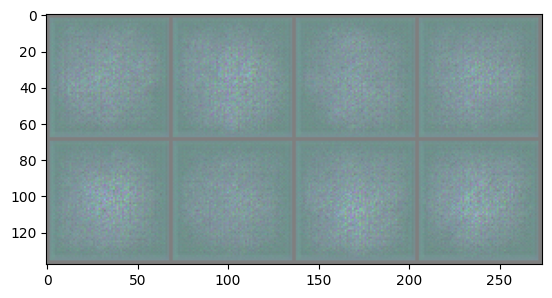

{'learning_rate': 5.7963939533849734e-05, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 150}
Epoch: 0
gen_loss: 0.7445378303527832, dis_loss: 1.3893848657608032
gen_loss: 0.7391589879989624, dis_loss: 1.388563632965088
gen_loss: 0.7349212169647217, dis_loss: 1.387970209121704
gen_loss: 0.7299426794052124, dis_loss: 1.387501835823059
gen_loss: 0.7243155241012573, dis_loss: 1.3868184089660645


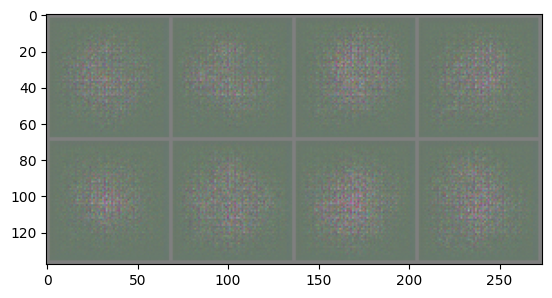

{'learning_rate': 0.0002481628922836826, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 150}
Epoch: 0
gen_loss: 0.7320701479911804, dis_loss: 1.3879599571228027
gen_loss: 0.7134007215499878, dis_loss: 1.387215256690979
gen_loss: 0.7057443857192993, dis_loss: 1.3844375610351562
gen_loss: 0.6749814748764038, dis_loss: 1.3790361881256104
gen_loss: 0.7360128164291382, dis_loss: 1.3602120876312256


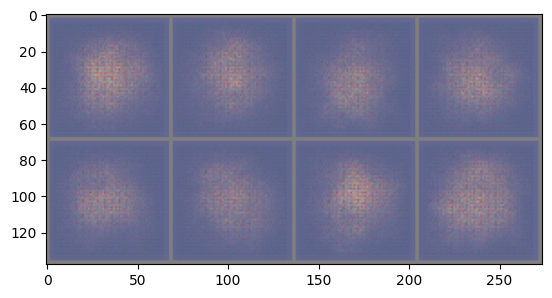

{'learning_rate': 3.5696988468260624e-05, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 150}
Epoch: 0
gen_loss: 0.6821019053459167, dis_loss: 1.386426568031311
gen_loss: 0.68252032995224, dis_loss: 1.386324167251587
gen_loss: 0.6832512021064758, dis_loss: 1.3861960172653198
gen_loss: 0.6830921173095703, dis_loss: 1.3861489295959473
gen_loss: 0.6827594637870789, dis_loss: 1.3860197067260742


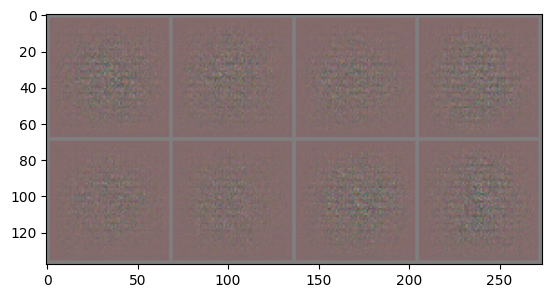

{'learning_rate': 4.029611320200404e-05, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 150}
Epoch: 0
gen_loss: 0.7812744379043579, dis_loss: 1.3943285942077637
gen_loss: 0.7768387794494629, dis_loss: 1.3932626247406006
gen_loss: 0.7730287313461304, dis_loss: 1.3923639059066772
gen_loss: 0.7686610221862793, dis_loss: 1.3917148113250732
gen_loss: 0.7640401721000671, dis_loss: 1.3909363746643066


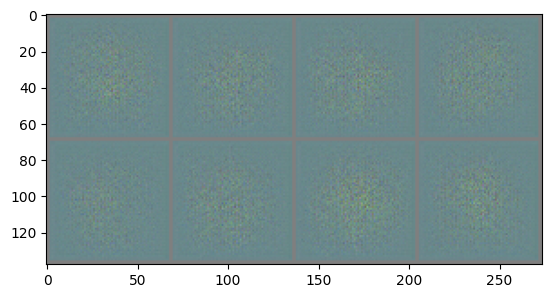

{'learning_rate': 0.0002481628922836826, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 75}
Epoch: 0
gen_loss: 0.672860860824585, dis_loss: 1.3864796161651611
gen_loss: 0.6739025115966797, dis_loss: 1.3857474327087402
gen_loss: 0.6710813641548157, dis_loss: 1.3836065530776978
gen_loss: 0.6832558512687683, dis_loss: 1.374885082244873
gen_loss: 0.5413374900817871, dis_loss: 1.3513472080230713


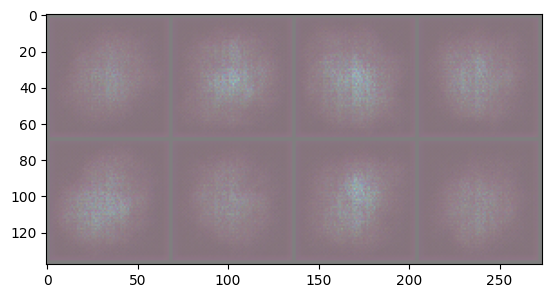

{'learning_rate': 7.386199822079358e-05, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 75}
Epoch: 0
gen_loss: 0.6453704833984375, dis_loss: 1.3895083665847778
gen_loss: 0.6465891003608704, dis_loss: 1.3884299993515015
gen_loss: 0.6514958739280701, dis_loss: 1.3880927562713623
gen_loss: 0.6529404520988464, dis_loss: 1.3873775005340576
gen_loss: 0.6564481258392334, dis_loss: 1.3868255615234375


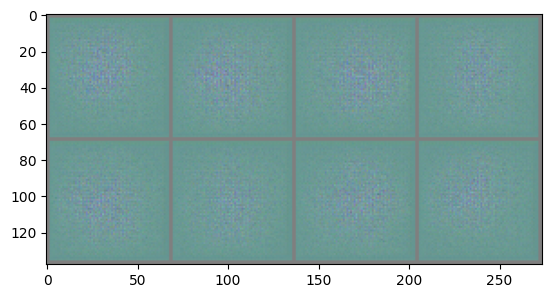

{'learning_rate': 0.0001725210549942041, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 150}
Epoch: 0
gen_loss: 0.6553353071212769, dis_loss: 1.3883056640625
gen_loss: 0.659247636795044, dis_loss: 1.3878846168518066
gen_loss: 0.6706030368804932, dis_loss: 1.3865877389907837
gen_loss: 0.6837634444236755, dis_loss: 1.3835816383361816
gen_loss: 0.6736671924591064, dis_loss: 1.3760535717010498


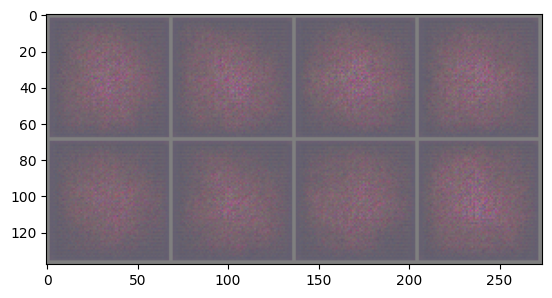

{'learning_rate': 7.386199822079358e-05, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 150}
Epoch: 0
gen_loss: 0.7530576586723328, dis_loss: 1.390446662902832
gen_loss: 0.7467548251152039, dis_loss: 1.389261245727539
gen_loss: 0.7394384145736694, dis_loss: 1.3881196975708008
gen_loss: 0.7319223880767822, dis_loss: 1.3868639469146729
gen_loss: 0.7230706214904785, dis_loss: 1.3851919174194336


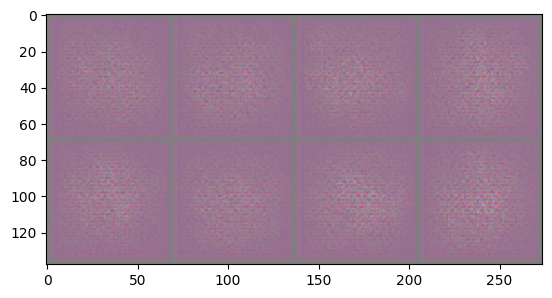

{'learning_rate': 4.029611320200404e-05, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 75}
Epoch: 0
gen_loss: 0.6731448769569397, dis_loss: 1.3868582248687744
gen_loss: 0.675597071647644, dis_loss: 1.386568307876587
gen_loss: 0.6774242520332336, dis_loss: 1.3864359855651855
gen_loss: 0.6792832612991333, dis_loss: 1.3862216472625732
gen_loss: 0.6817255020141602, dis_loss: 1.3859531879425049


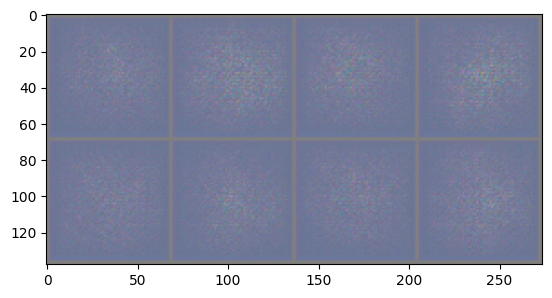

{'learning_rate': 0.0002198392648862289, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 150}
Epoch: 0
gen_loss: 0.7076947093009949, dis_loss: 1.3869725465774536
gen_loss: 0.6966791749000549, dis_loss: 1.3862931728363037
gen_loss: 0.6800746917724609, dis_loss: 1.3854789733886719
gen_loss: 0.6569164991378784, dis_loss: 1.3831342458724976
gen_loss: 0.6539649963378906, dis_loss: 1.3768973350524902


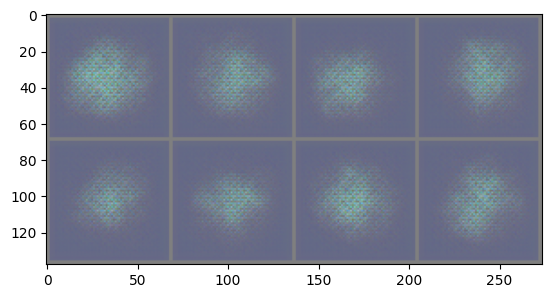

{'learning_rate': 0.0002198392648862289, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 75}
Epoch: 0
gen_loss: 0.7511751651763916, dis_loss: 1.3910081386566162
gen_loss: 0.7161605358123779, dis_loss: 1.3890529870986938
gen_loss: 0.6464225053787231, dis_loss: 1.385087490081787
gen_loss: 0.6848980188369751, dis_loss: 1.382811188697815
gen_loss: 0.6561859250068665, dis_loss: 1.3761568069458008


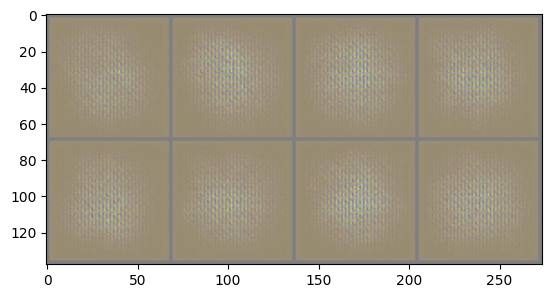

{'learning_rate': 0.00015283067326587687, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 150}
Epoch: 0
gen_loss: 0.6787756085395813, dis_loss: 1.3866748809814453
gen_loss: 0.6835936903953552, dis_loss: 1.3863208293914795
gen_loss: 0.684287428855896, dis_loss: 1.3859400749206543
gen_loss: 0.6950726509094238, dis_loss: 1.385177493095398
gen_loss: 0.7026573419570923, dis_loss: 1.3826252222061157


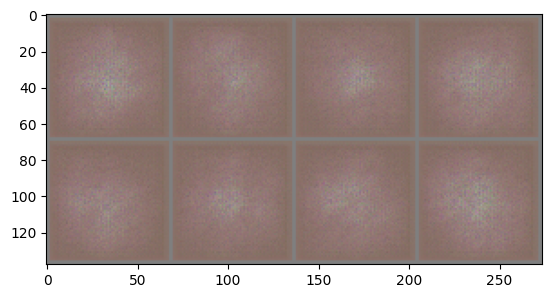

{'learning_rate': 0.0001725210549942041, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 75}
Epoch: 0
gen_loss: 0.7336438894271851, dis_loss: 1.3881242275238037
gen_loss: 0.7234439849853516, dis_loss: 1.3876399993896484
gen_loss: 0.711067259311676, dis_loss: 1.3868129253387451
gen_loss: 0.6961203813552856, dis_loss: 1.3855319023132324
gen_loss: 0.6757404804229736, dis_loss: 1.3830058574676514


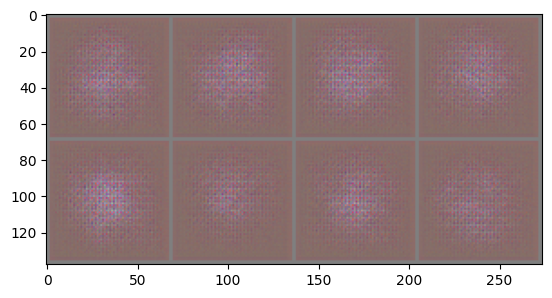

{'learning_rate': 8.337822234717882e-05, 'n_generator_features': 10, 'n_discriminator_features': 40, 'generator_input_size': 75}
Epoch: 0
gen_loss: 0.736638605594635, dis_loss: 1.3888070583343506
gen_loss: 0.7294541597366333, dis_loss: 1.387686848640442
gen_loss: 0.7212391495704651, dis_loss: 1.3866369724273682
gen_loss: 0.71070796251297, dis_loss: 1.3853380680084229
gen_loss: 0.6996163129806519, dis_loss: 1.3831976652145386


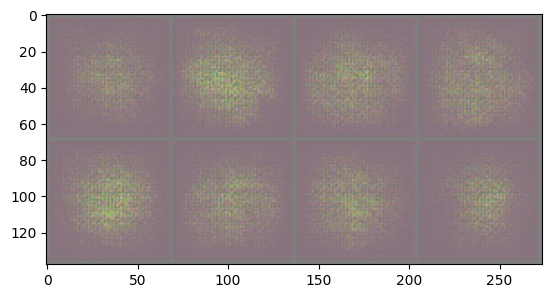

In [14]:
# Below, we train several models and select hyperparameters which were successful
# for further iterations.

end_batch_early = True
if end_batch_early:
    max_batches = int(2**14 / anime_loader.batch_size)
else:
    max_batches = len(anime_loader.dataset) // anime_loader.batch_size
max_batches = 4
callbacks = [
    VerboseTrainingCallback(max_batches // 4),
    SnapshotCallback(8, interval=max_batches // 4),
    StopWhenNoLearning()
]
if end_batch_early:
    callbacks.append(EndOnBatchCallback(max_batches))
print(f"Max batches: {max_batches}")

gan_tuner.tune_model(anime_loader, 15, 1, max_batches, callbacks)

In [10]:
# Use good parameters from above
# NOTE: if we had a metric, this could be programmatic...

params = {'learning_rate': 0.000379269019073225, 'n_generator_features': 52, 'n_discriminator_features': 36, 'generator_input_size': 75}
loop = build_gan_loop(**params)
n_batches = len(anime_dataset) // anime_loader.batch_size
callbacks = [
    VerboseTrainingCallback(n_batches // 4),
    SnapshotCallback(8, interval=n_batches // 4)
]


Epoch: 0
gen_loss: 0.6506577730178833, dis_loss: 1.3903460502624512
gen_loss: 0.6864397525787354, dis_loss: 0.7001587748527527
gen_loss: 0.6985176801681519, dis_loss: 1.386323094367981
gen_loss: 0.6965935230255127, dis_loss: 1.3863060474395752
gen_loss: 0.6950161457061768, dis_loss: 1.3862979412078857


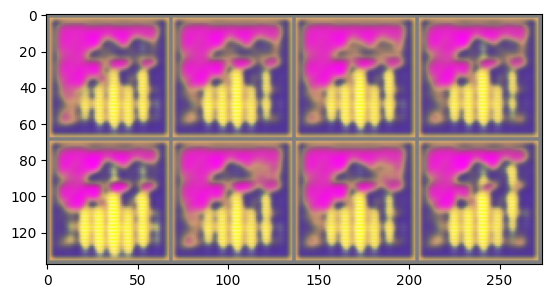

Epoch: 1
gen_loss: 0.6950082182884216, dis_loss: 1.3862978219985962
gen_loss: 0.6939687132835388, dis_loss: 1.3862950801849365
gen_loss: 0.6934282779693604, dis_loss: 1.3862943649291992
gen_loss: 0.693216860294342, dis_loss: 1.3862943649291992
gen_loss: 0.6931586265563965, dis_loss: 1.3862943649291992


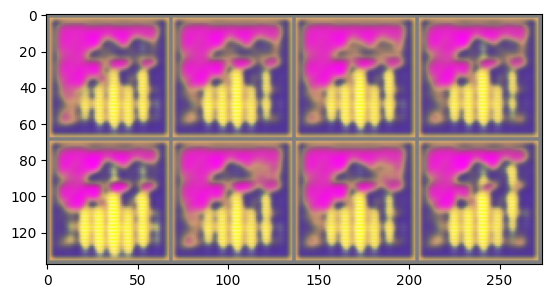

Epoch: 2
gen_loss: 0.6931584477424622, dis_loss: 1.3862943649291992
gen_loss: 0.6931482553482056, dis_loss: 1.3862943649291992
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992


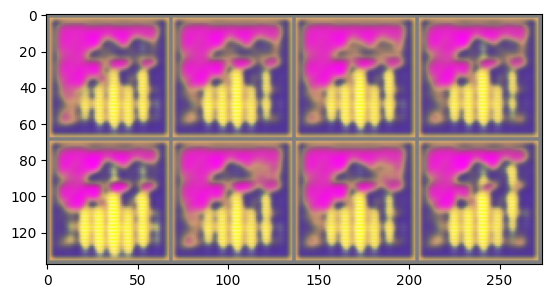

Epoch: 3
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992


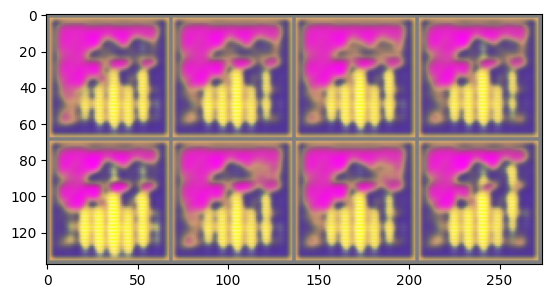

Epoch: 4
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992


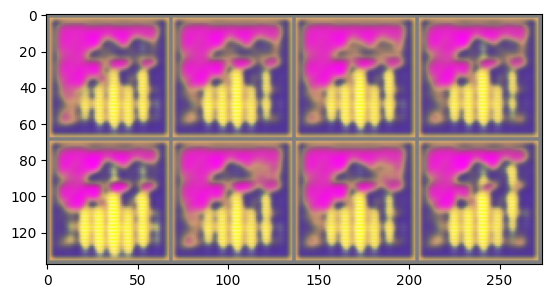

Epoch: 5
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992
gen_loss: 0.6931473016738892, dis_loss: 1.3862943649291992


KeyboardInterrupt: 

In [11]:
loop.fit(anime_loader, 10, callbacks)